# Install Transformers Library

In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.utils import resample

device = torch.device("cuda")

# Load Dataset

In [92]:
df = pd.read_csv("preprocessed_data.csv")
df.head()

,email,label
0,risk ops problem load erac crude option spread...,0
1,message ideal notebook user pcmcia cdrw drive ...,1
2,congratulation lottery coordinator internation...,1
3,hello would like spend y yyour druggs mandmany...,1
4,free prescription online limit time nline phra...,1


In [93]:
df.shape

(60122, 2)

In [94]:
df.dropna(inplace=True)

In [95]:
df["label"].value_counts(normalize=True)

s = df.label.value_counts()

print(
    "There are",
    s.values[0],
    "spam emails and",
    s.values[1],
    "ham emails in the dataset",
)

There are 37672 spam emails and 19054 ham emails in the dataset


In [97]:
df.label.value_counts()

1    37672
0    19054
Name: label, dtype: int64

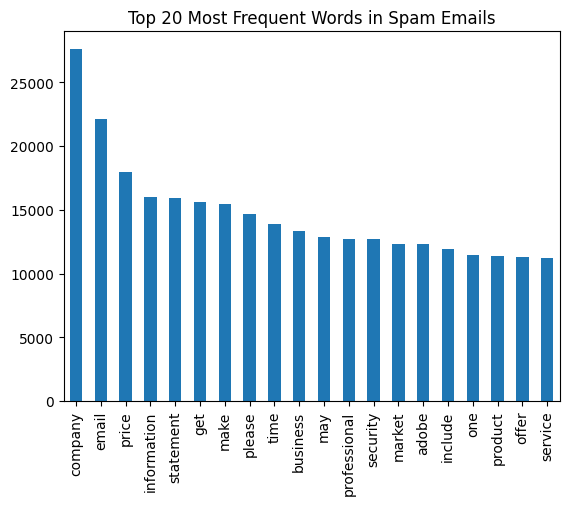

In [98]:
top_spam = pd.Series(" ".join(df["email"][df["label"] == 1]).split()).value_counts()[
    :20
]
top_spam.plot(kind="bar")
plt.title("Top 20 Most Frequent Words in Spam Emails")
plt.show()

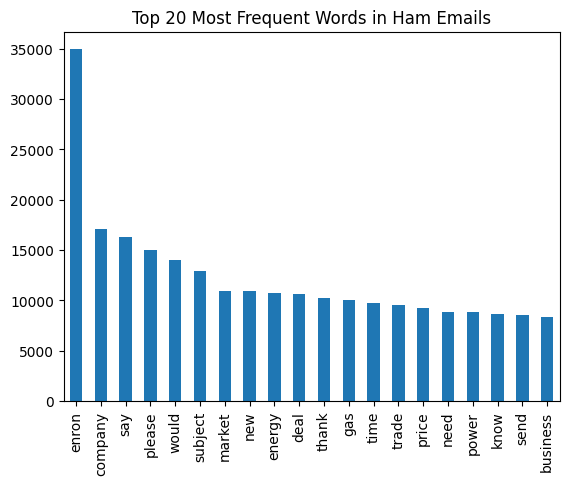

In [99]:
top_ham = pd.Series(" ".join(df["email"][df["label"] == 0]).split()).value_counts()[:20]
top_ham.plot(kind="bar")
plt.title("Top 20 Most Frequent Words in Ham Emails")
plt.show()

# Split train dataset into train, validation and test sets

In [100]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df["email"], df["label"], random_state=2018, test_size=0.3, stratify=df["label"]
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels
)

# Import BERT Model and BERT Tokenizer

In [101]:
bert = AutoModel.from_pretrained("bert-base-uncased", return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained(
    "bert-base-uncased",
)

In [102]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [103]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

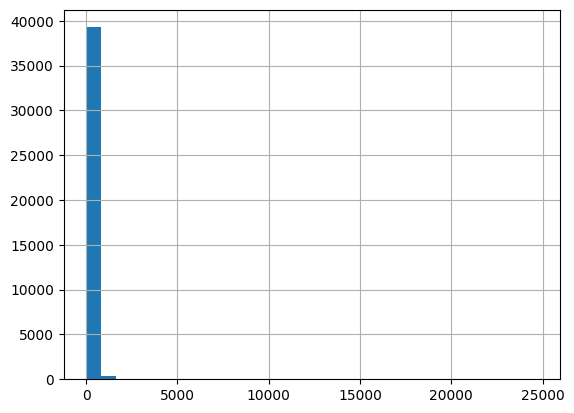

In [104]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins=30)

In [105]:
# tokenize and encode sequences in the training set
max_seq_len = 25
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False,
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False,
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [106]:
# for train set
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [107]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [108]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [109]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):
        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [110]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [111]:
# optimizer from hugging face transformers
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [112]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
print(class_wts)

[1.48852901 0.75290102]


In [113]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [114]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

In [115]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.

            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Start Model Training

In [116]:
# set initial loss to infinite
best_valid_loss = float("inf")

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):
    print("\n Epoch {:} / {:}".format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "saved_weights.pt")

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\nTraining Loss: {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")


 Epoch 1 / 10
  Batch    50  of  1,241.
  Batch   100  of  1,241.
  Batch   150  of  1,241.
  Batch   200  of  1,241.
  Batch   250  of  1,241.
  Batch   300  of  1,241.
  Batch   350  of  1,241.
  Batch   400  of  1,241.
  Batch   450  of  1,241.
  Batch   500  of  1,241.
  Batch   550  of  1,241.
  Batch   600  of  1,241.
  Batch   650  of  1,241.
  Batch   700  of  1,241.
  Batch   750  of  1,241.
  Batch   800  of  1,241.
  Batch   850  of  1,241.
  Batch   900  of  1,241.
  Batch   950  of  1,241.
  Batch 1,000  of  1,241.
  Batch 1,050  of  1,241.
  Batch 1,100  of  1,241.
  Batch 1,150  of  1,241.
  Batch 1,200  of  1,241.

Evaluating...
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Training Loss: 0.418
Validation Loss: 0.279

 Epoch 2 / 10
  Batch    50  of  1,241.
  Batch   100  of  1,241.
  Batch   150  of  1,241.
  Batch   200  of  1,241.
  Batch   250  of  1,241.
  Batch   300  of  1,241.


# Load Saved Model

In [117]:
# load weights of best model
path = "saved_weights.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [118]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [119]:
preds

array([[-7.5269667e-03, -4.8930297e+00],
       [-1.1135093e+00, -3.9809904e-01],
       [-4.0353518e+00, -1.7837582e-02],
       ...,
       [-3.8143275e-03, -5.5708938e+00],
       [-5.6615734e+00, -3.4830638e-03],
       [-3.0571463e+00, -4.8163109e-02]], dtype=float32)

In [120]:
# model's performance
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2858
           1       0.96      0.91      0.93      5651

    accuracy                           0.91      8509
   macro avg       0.90      0.92      0.91      8509
weighted avg       0.92      0.91      0.92      8509



In [121]:
preds

array([0, 1, 1, ..., 0, 1, 1])

In [122]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,2647,211
1,515,5136
